# Read in the data

In [54]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [55]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [56]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [57]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [58]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [59]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [60]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [61]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [62]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [63]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

In [64]:
%matplotlib inline


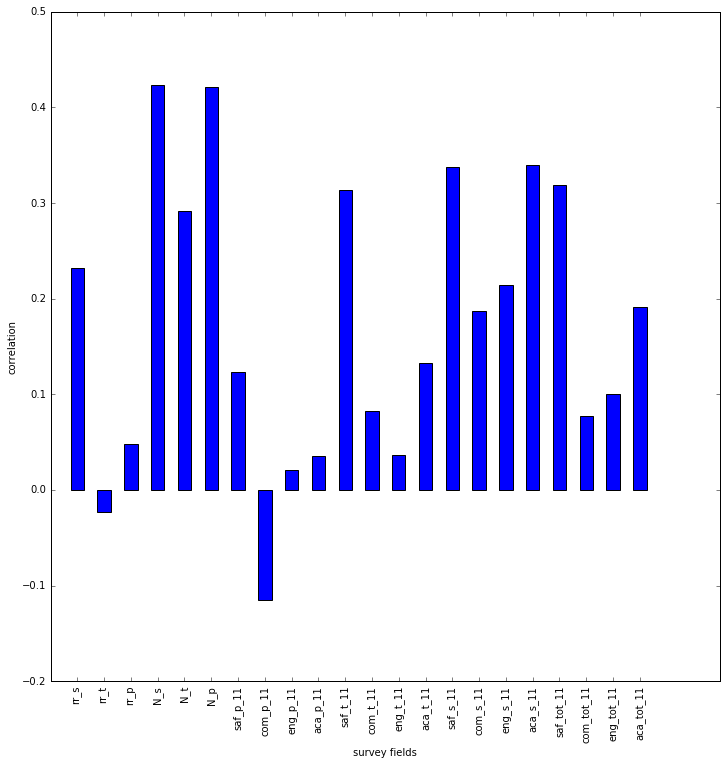

In [65]:
fig,ax=plt.subplots(figsize=(12,12))
#print(type(correlations))
bar_hts = correlations[survey_fields].tolist()
bar_pos = numpy.arange(0.75, len(survey_fields)+0.75)
tick_pos = range(1,len(survey_fields)+1)
#print(tick_pos)
#print(bar_pos)
#print(bar_hts)
ax.bar(bar_pos, bar_hts, width=0.5)
ax.set_xticks(tick_pos)
ax.set_xticklabels(survey_fields,rotation=90)
ax.set_xlabel("survey fields")
ax.set_ylabel("correlation")
plt.show()

Students rating on safety and respect score has a strong positive correlation with sat_scores. It indicates that the safer and respect the students get helps them perform better in SAT.

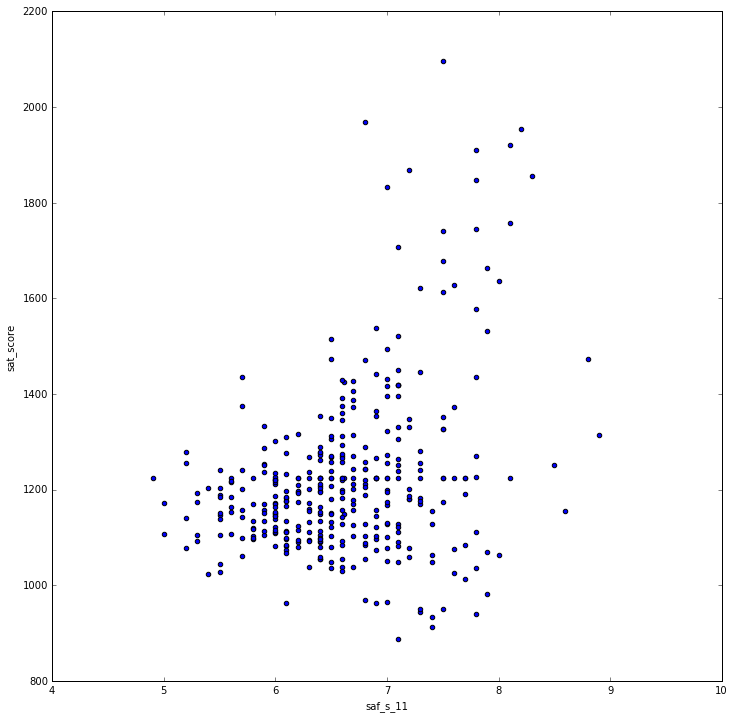

In [66]:
fig,ax=plt.subplots(figsize=(12,12))
ax.scatter(combined['saf_s_11'], combined['sat_score'])
ax.set_xlabel('saf_s_11')
ax.set_ylabel('sat_score')
plt.show()

Not a clear correlation between safety and sat_scores. On an average the sat_scores tend to increase with safety ratings. 

In [67]:
combined.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,0,129.028846,197.038462,...,Then to New York City residents,0,0,0,0,0,"220 Henry Street\nNew York, NY 10002\n(40.7137...",40.713764,-73.985260,01
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.000000,49.000000,...,0,0,0,0,0,0,"200 Monroe Street\nNew York, NY 10002\n(40.712...",40.712332,-73.984797,01
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0,EAST SIDE COMMUNITY HS,19.000000,21.000000,...,0,0,0,0,0,0,"420 East 12 Street\nNew York, NY 10009\n(40.72...",40.729783,-73.983041,01
3,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0,0,129.028846,197.038462,...,0,0,0,0,0,0,"145 Stanton Street\nNew York, NY 10002\n(40.72...",40.720569,-73.985673,01
4,01M539,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",159,522.0,574.0,525.0,1621.0,"NEW EXPLORATIONS SCI,TECH,MATH",255.000000,377.000000,...,0,0,0,0,0,0,"111 Columbia Street\nNew York, NY 10002\n(40.7...",40.718725,-73.979426,01


In [68]:
avg_score = combined.groupby("school_dist").agg(numpy.mean)
avg_score.reset_index(inplace=True)
#print(avg_score)
#print("type={}".format(type(avg_score)))

In [69]:
cols = ['lat', 'lon']
des = combined[cols].describe()
#print(des)
#print("destype={}".format(type(des)))

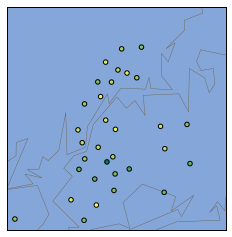

In [70]:
avg_safety_scores = avg_score[['saf_s_11', 'saf_t_11', 'saf_p_11', 'saf_tot_11']]
from mpl_toolkits.basemap import Basemap
e_map_area = 0.05
latmin = des.loc['min']['lat']
latmax = des.loc['max']['lat']
lonmin = des.loc['min']['lon']
lonmax = des.loc['max']['lon']
m=Basemap(projection='merc', 
          llcrnrlat=latmin+e_map_area, 
          urcrnrlat=latmax+e_map_area, 
          llcrnrlon=lonmin+e_map_area, 
          urcrnrlon=lonmax+e_map_area, 
          resolution='i')
m.drawmapboundary(fill_color='#85a6d9')
m.drawcoastlines(color='#6D5F47', linewidth=0.4)
m.drawrivers(color='#6d5f47', linewidth=0.4)
lons=avg_score['lon'].tolist()
lats=avg_score['lat'].tolist()
m.scatter(lons, lats, s=20, zorder=2, latlon=True, c=avg_score['saf_tot_11'], cmap='summer')
plt.show()

It looks like the safety rating is lower in Brooklyn school district. In upper Manhattan, bronx and Queens the rating is relatively higher.

# Racial correlation with SAT score

[0.6207177638526802, 0.5707302200214872, -0.2841394684581478, -0.39698493078147196]
<class 'list'>


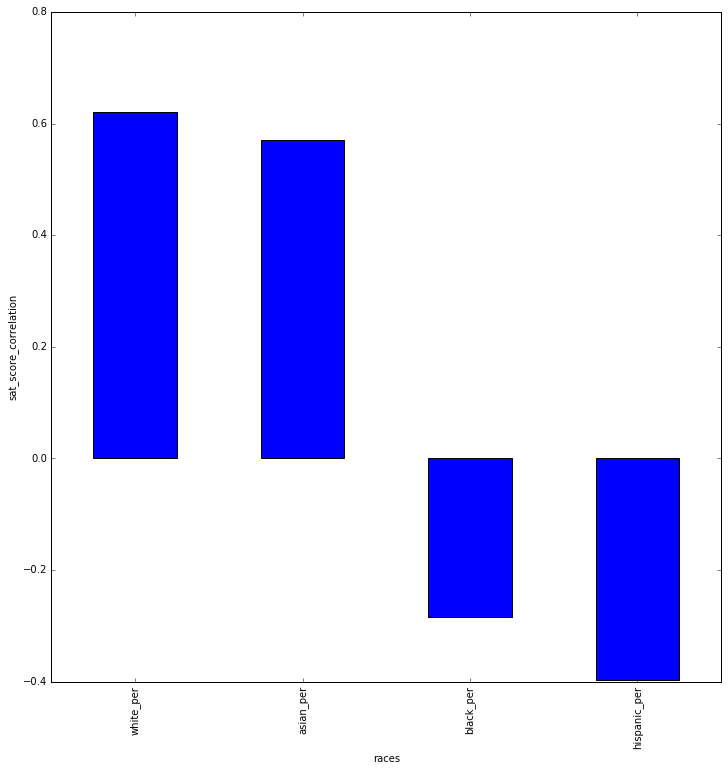

In [71]:
correlations = combined.corr()
correlations = correlations['sat_score']
races = ['white_per', 'asian_per', 'black_per', 'hispanic_per']
bar_hts = correlations[races].tolist()
print(bar_hts)
print(type(bar_hts))
bar_pos = numpy.arange(len(races))+0.75
bar_ticks = range(1,len(races)+1)
fig,ax=plt.subplots(figsize=(12,12))
ax.bar(bar_pos, bar_hts, width=0.5)
ax.set_xticks(bar_ticks)
ax.set_xticklabels(races, rotation=90)
ax.set_xlabel('races')
ax.set_ylabel('sat_score_correlation')
plt.show()

Schools with white and asian students tend to do well on SATs whereas those with hispanics tend to not do well on SAT. 

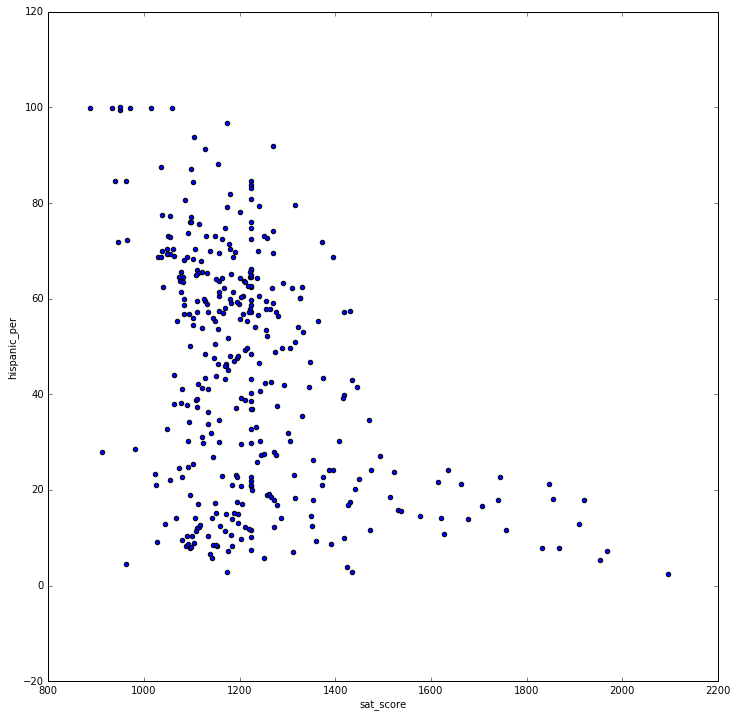

In [72]:
fig, ax=plt.subplots(figsize=(12,12))
ax.scatter(combined['sat_score'], combined['hispanic_per'])
ax.set_xlabel("sat_score")
ax.set_ylabel("hispanic_per")
plt.show()

The correlation is not negatively strong b/w sat_score and hispanic_per. however schools with a large hispanic population have lower sat scores.

In [73]:
hispanicMajority = combined[combined['hispanic_per']>95]
print(hispanicMajority['SCHOOL NAME'])

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


Most of the schools are schools that cater to newly arriving hispanic immigrants. They are not fluent in English, hence may explain their lower scores in SAT

In [74]:
hispanicMinority = combined[(combined['hispanic_per']<10)&(combined['sat_score']>1800)]
print(hispanicMinority['SCHOOL NAME'])

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


Schools with >1800 sat_score and lower than 10% hispanic population are elite schools in NYC operated by NYC Department of Education. It is tough to get into these schools as they select only the bright students through an entrance examination every year.

# Gender differences in SAT scores

In [75]:
print(correlations[['male_per', 'female_per']])

male_per     -0.112062
female_per    0.112108
Name: sat_score, dtype: float64


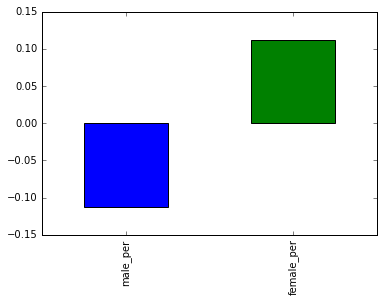

In [76]:
correlations[['male_per', 'female_per']].plot.bar()

Not a strong correlation b/w SAT scores and gender

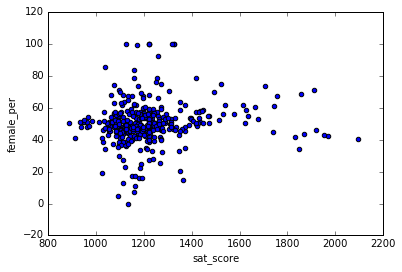

In [77]:
combined.plot.scatter("sat_score", "female_per")

Not a strong correlation b/w female_per and sat_score. however, there's a tendency in select dataset where sat_score has a negative correlation with female_per when female_per>40%

In [78]:
femaleMajority = combined[(combined['female_per']>60) & (combined['sat_score']>1700)]
print(femaleMajority["SCHOOL NAME"])

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


These schools are high-performing schools. 

# AP exam takers vs SAT scores

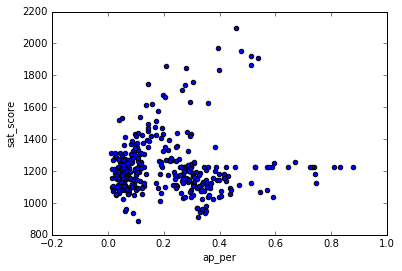

In [81]:
combined["ap_per"] = combined["AP Test Takers "]/combined["total_enrollment"]
combined.plot.scatter("ap_per", "sat_score")

There's some positive correlation between percentage of students taking AP test and sat_score. But it's not strong though.